<a href="https://colab.research.google.com/github/Naidala/CNN_medical_imaging/blob/main/Task5_Ensemble4Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CONFUSION MATRIXES

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import itertools

#Plotting of the Matrix confusion
def plot_confusion_matrix(cm,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy
  cmap = plt.get_cmap('Blues')

  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:,}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xticks(range(0,4),)
  plt.yticks(range(0,4),)
  plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
  plt.show()

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from google.colab import drive
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import copy

drive.mount('/content/drive/')
out_path = "/content/drive/My Drive/CompIntProjects/FinalProject2019/numpy data/"

def load_data():
  test_images = np.load(os.path.join(out_path,'public_test_tensor.npy'))
  test_labels = np.load(os.path.join(out_path,'public_test_labels.npy'))
  test_images = test_images.astype('float32') / 65535
  test_images = test_images.reshape((len(test_images), 150, 150, 1))
  test_images = test_images[1:len(test_images):2]
  test_labels = test_labels[1:len(test_labels):2]
  return test_images, test_labels

def labels2categorical(labels):
  for i in range(0,len(labels)):
    labels[i] = labels[i] - 1
  return to_categorical(labels, num_classes = 4)

def ml2categorical_pred(pred_ml):   # convert prediction from multiLabel to categorical
  pred_ctg = []
  for i in range(0,len(pred_ml)):
    new_pred = [0,0,0,0]
    new_pred[0] = pred_ml[i][2]*pred_ml[i][3]   # la categorica è il prodotto di due eventi previsti indipendentemente
    new_pred[1] = pred_ml[i][0]*pred_ml[i][3]   # che devono però verificarsi simultaneamente. Esempio:
    new_pred[2] = pred_ml[i][2]*pred_ml[i][1]   # multilabel predice massa maligna come elevata probabilità in prima e ultima posizione [1, 0, 0, 1];
    new_pred[3] = pred_ml[i][0]*pred_ml[i][1]   # per passare alla categorica - per cui massa maligna occupa la seconda cella - si inserisce nella cella [1]
    pred_ctg.append(new_pred)                   # il prodotto (indicante ET tra due eventi) tra le celle [0] e [3] della multilabel
  return pred_ctg

TensorFlow 1.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


##MULTI-LABEL

In [ ]:
from tensorflow.keras.models import load_model
save_dir = "/content/drive/My Drive/CompIntProjects/4classes"
model_ml = load_model(os.path.join(save_dir,"4classes_multiLabel.h5"))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
test_images_4, test_labels_4 = load_data()
true = np.argmax(labels2categorical(test_labels_4),axis = 1)    # true label in categorical format

prediction = model_ml.predict(test_images_4) # prediction in multilabel
pred = ml2categorical_pred(prediction) # prediction in cat
pred = np.reshape(pred,(len(pred),4))
pred = np.argmax(pred,axis =1)

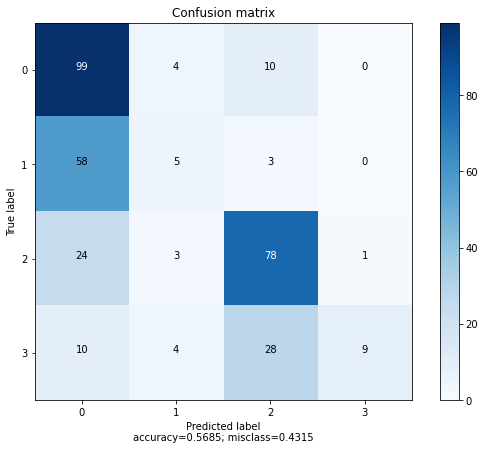

In [ ]:
cm = metrics.confusion_matrix(true,pred)
plot_confusion_matrix(cm,normalize=True)

## AUGMENTED

In [ ]:
test_images_4, test_labels_4 = load_data()
test_labels_4 = labels2categorical(test_labels_4)

In [ ]:
from tensorflow.keras.models import load_model
save_dir = "/content/drive/My Drive/CompIntProjects/4classes"
model_aug = load_model(os.path.join(save_dir,"4classes_aug.h5"))
test_loss, test_acc = model_aug.evaluate(test_images_4, test_labels_4)
print('test_acc: ', test_acc)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
336/336 [==============================] - 0s 670us/sample - loss: 1.0454 - acc: 0.5268
test_acc:  0.52678573


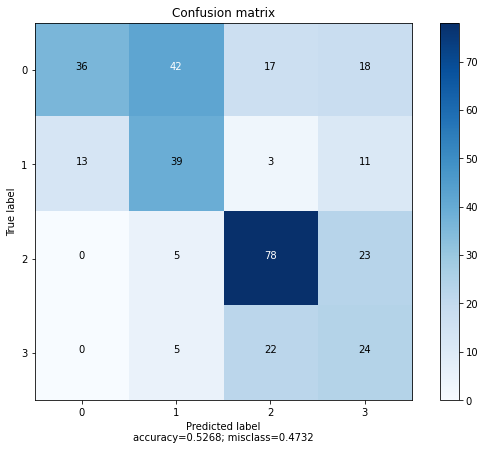

In [ ]:
pred = np.argmax(model_aug.predict(test_images_4),axis =1)
true = np.argmax(test_labels_4,axis = 1)
cm = metrics.confusion_matrix(true,pred)
plot_confusion_matrix(cm,normalize=False)

##PRE-TRAINED

In [ ]:
test_images_fine_4 = copy.deepcopy(test_images_4.repeat(repeats = 3, axis = 3))
test_labels_fine_4 = copy.deepcopy(test_labels_4)

from tensorflow.keras.models import load_model
save_dir = "/content/drive/My Drive/CompIntProjects/4classes"
model_fine = load_model(os.path.join(save_dir,"4classes_fine.h5"))

test_loss, test_acc = model_fine.evaluate(test_images_fine_4, test_labels_fine_4)
print('test_acc: ', test_acc)

336/336 [==============================] - 1s 4ms/sample - loss: 0.8111 - acc: 0.6637
test_acc:  0.66369045


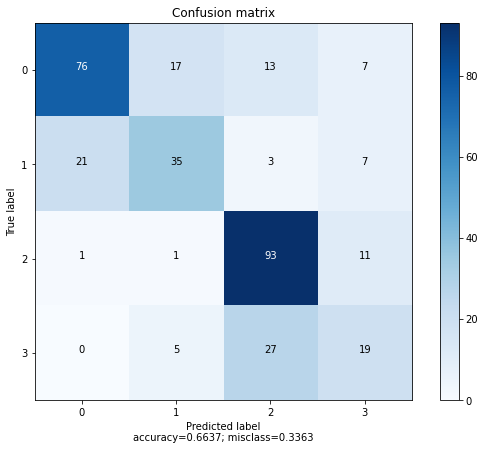

In [ ]:
pred = np.argmax(model_fine.predict(test_images_fine_4),axis =1)
true = np.argmax(test_labels_fine_4,axis = 1)
cm = metrics.confusion_matrix(true,pred)
plot_confusion_matrix(cm)

#ENSEMBLING

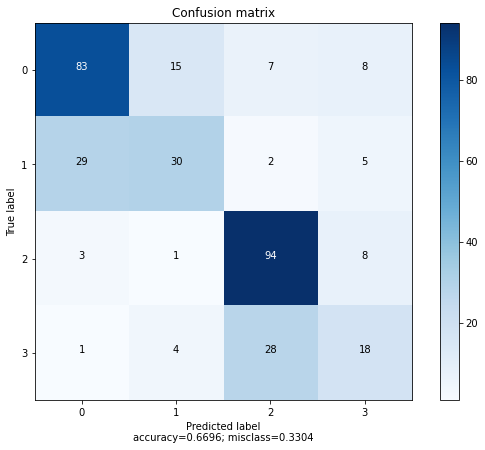

In [ ]:
preds_fine = model_fine.predict(test_images_fine_4)
preds_aug = model_aug.predict(test_images_4)
preds_ml = ml2categorical_pred(model_ml.predict(test_images_4))
preds_ml = np.reshape(preds_ml,(len(preds_ml),4))

final_preds = (preds_fine*4 + preds_aug*2 + preds_ml*3)
final_preds_new = np.argmax((final_preds),axis =1)

cm = metrics.confusion_matrix(true,final_preds_new)
plot_confusion_matrix(cm)